In [0]:
# import packages
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np

In [0]:
# define GAN class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        fig.savefig("./images/%d_epochs.png" % epoch)
        plt.close()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.800557, acc.: 37.50%] [G loss: 0.698253]


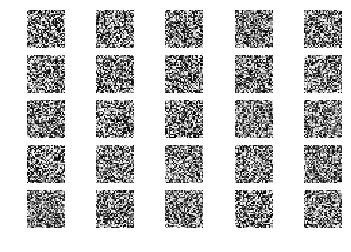

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.416049, acc.: 79.69%] [G loss: 0.719099]
2 [D loss: 0.403561, acc.: 79.69%] [G loss: 0.861723]
3 [D loss: 0.313891, acc.: 84.38%] [G loss: 0.925695]
4 [D loss: 0.301563, acc.: 85.94%] [G loss: 1.120456]
5 [D loss: 0.259589, acc.: 95.31%] [G loss: 1.243817]
6 [D loss: 0.203722, acc.: 98.44%] [G loss: 1.338675]
7 [D loss: 0.195570, acc.: 98.44%] [G loss: 1.428884]
8 [D loss: 0.197311, acc.: 98.44%] [G loss: 1.581725]
9 [D loss: 0.154496, acc.: 100.00%] [G loss: 1.724869]
10 [D loss: 0.120104, acc.: 100.00%] [G loss: 1.773532]
11 [D loss: 0.138020, acc.: 100.00%] [G loss: 1.763982]
12 [D loss: 0.113798, acc.: 100.00%] [G loss: 1.894335]
13 [D loss: 0.098899, acc.: 100.00%] [G loss: 2.029679]
14 [D loss: 0.096957, acc.: 100.00%] [G loss: 1.996260]
15 [D loss: 0.084390, acc.: 100.00%] [G loss: 2.102004]
16 [D loss: 0.106711, acc.: 100.00%] [G loss: 2.090618]
17 [D loss: 0.078017, acc.: 100.00%] [G loss: 2.185185]
18 [D loss: 0.098075, acc.: 100.00%] [G loss: 2.224454]
19 [D los

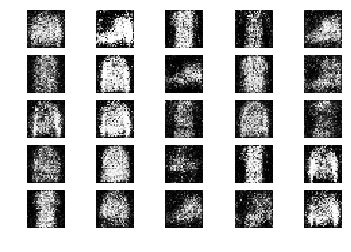

501 [D loss: 0.594120, acc.: 70.31%] [G loss: 1.079784]
502 [D loss: 0.591650, acc.: 73.44%] [G loss: 0.931017]
503 [D loss: 0.608369, acc.: 67.19%] [G loss: 0.907423]
504 [D loss: 0.643629, acc.: 65.62%] [G loss: 0.939434]
505 [D loss: 0.570618, acc.: 73.44%] [G loss: 0.893865]
506 [D loss: 0.602437, acc.: 65.62%] [G loss: 0.975257]
507 [D loss: 0.572634, acc.: 71.88%] [G loss: 1.023131]
508 [D loss: 0.615759, acc.: 65.62%] [G loss: 0.958033]
509 [D loss: 0.635864, acc.: 64.06%] [G loss: 0.906016]
510 [D loss: 0.588526, acc.: 71.88%] [G loss: 0.916991]
511 [D loss: 0.645606, acc.: 60.94%] [G loss: 0.923074]
512 [D loss: 0.660192, acc.: 57.81%] [G loss: 0.887365]
513 [D loss: 0.581836, acc.: 68.75%] [G loss: 0.888193]
514 [D loss: 0.614205, acc.: 71.88%] [G loss: 0.963375]
515 [D loss: 0.570875, acc.: 65.62%] [G loss: 1.033718]
516 [D loss: 0.630900, acc.: 57.81%] [G loss: 1.082863]
517 [D loss: 0.593100, acc.: 65.62%] [G loss: 1.040252]
518 [D loss: 0.616504, acc.: 71.88%] [G loss: 0.

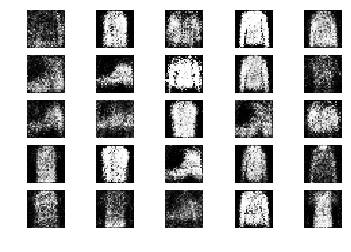

1001 [D loss: 0.594723, acc.: 68.75%] [G loss: 0.881955]
1002 [D loss: 0.616254, acc.: 75.00%] [G loss: 0.883197]
1003 [D loss: 0.679633, acc.: 56.25%] [G loss: 0.818997]
1004 [D loss: 0.647617, acc.: 65.62%] [G loss: 0.802088]
1005 [D loss: 0.639661, acc.: 62.50%] [G loss: 0.891770]
1006 [D loss: 0.589641, acc.: 73.44%] [G loss: 0.889197]
1007 [D loss: 0.627883, acc.: 65.62%] [G loss: 0.855557]
1008 [D loss: 0.625085, acc.: 64.06%] [G loss: 0.879798]
1009 [D loss: 0.626503, acc.: 60.94%] [G loss: 0.754049]
1010 [D loss: 0.608122, acc.: 57.81%] [G loss: 0.830334]
1011 [D loss: 0.677285, acc.: 57.81%] [G loss: 0.831862]
1012 [D loss: 0.662712, acc.: 57.81%] [G loss: 0.793439]
1013 [D loss: 0.616762, acc.: 68.75%] [G loss: 0.796674]
1014 [D loss: 0.598188, acc.: 64.06%] [G loss: 0.881267]
1015 [D loss: 0.635689, acc.: 62.50%] [G loss: 0.846410]
1016 [D loss: 0.613687, acc.: 67.19%] [G loss: 0.900377]
1017 [D loss: 0.658027, acc.: 67.19%] [G loss: 0.843878]
1018 [D loss: 0.614005, acc.: 7

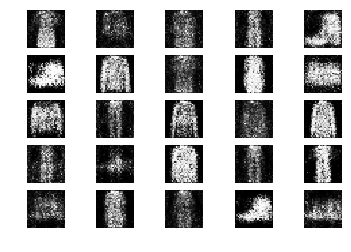

1501 [D loss: 0.603210, acc.: 67.19%] [G loss: 0.858487]
1502 [D loss: 0.633085, acc.: 60.94%] [G loss: 0.943291]
1503 [D loss: 0.593173, acc.: 81.25%] [G loss: 0.913628]
1504 [D loss: 0.648683, acc.: 64.06%] [G loss: 0.823685]
1505 [D loss: 0.661762, acc.: 57.81%] [G loss: 0.810566]
1506 [D loss: 0.620124, acc.: 57.81%] [G loss: 0.763432]
1507 [D loss: 0.592310, acc.: 75.00%] [G loss: 0.802565]
1508 [D loss: 0.617565, acc.: 67.19%] [G loss: 0.856092]
1509 [D loss: 0.611703, acc.: 68.75%] [G loss: 0.944947]
1510 [D loss: 0.623022, acc.: 67.19%] [G loss: 0.852209]
1511 [D loss: 0.697860, acc.: 51.56%] [G loss: 0.820968]
1512 [D loss: 0.673705, acc.: 57.81%] [G loss: 0.834590]
1513 [D loss: 0.641860, acc.: 60.94%] [G loss: 0.885941]
1514 [D loss: 0.599843, acc.: 71.88%] [G loss: 0.864312]
1515 [D loss: 0.612969, acc.: 65.62%] [G loss: 0.997243]
1516 [D loss: 0.650918, acc.: 57.81%] [G loss: 0.877122]
1517 [D loss: 0.655968, acc.: 57.81%] [G loss: 0.838107]
1518 [D loss: 0.637767, acc.: 6

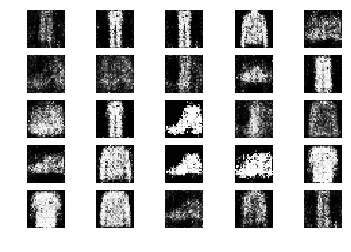

2001 [D loss: 0.624236, acc.: 59.38%] [G loss: 0.967766]
2002 [D loss: 0.661195, acc.: 56.25%] [G loss: 0.889939]
2003 [D loss: 0.642994, acc.: 65.62%] [G loss: 0.898736]
2004 [D loss: 0.656048, acc.: 68.75%] [G loss: 0.959496]
2005 [D loss: 0.579860, acc.: 70.31%] [G loss: 0.904131]
2006 [D loss: 0.618269, acc.: 67.19%] [G loss: 0.869290]
2007 [D loss: 0.581838, acc.: 73.44%] [G loss: 0.895560]
2008 [D loss: 0.612288, acc.: 73.44%] [G loss: 0.881129]
2009 [D loss: 0.546782, acc.: 76.56%] [G loss: 0.893567]
2010 [D loss: 0.733973, acc.: 51.56%] [G loss: 0.923988]
2011 [D loss: 0.629275, acc.: 67.19%] [G loss: 0.964882]
2012 [D loss: 0.640914, acc.: 65.62%] [G loss: 1.014971]
2013 [D loss: 0.617811, acc.: 62.50%] [G loss: 0.916553]
2014 [D loss: 0.707123, acc.: 57.81%] [G loss: 0.883808]
2015 [D loss: 0.651963, acc.: 65.62%] [G loss: 0.899660]
2016 [D loss: 0.580883, acc.: 68.75%] [G loss: 0.929084]
2017 [D loss: 0.638180, acc.: 67.19%] [G loss: 0.906838]
2018 [D loss: 0.642222, acc.: 6

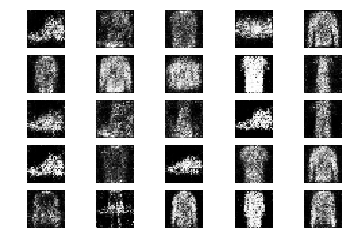

2501 [D loss: 0.656662, acc.: 59.38%] [G loss: 0.982068]
2502 [D loss: 0.661593, acc.: 57.81%] [G loss: 0.957969]
2503 [D loss: 0.693897, acc.: 57.81%] [G loss: 0.951557]
2504 [D loss: 0.586191, acc.: 75.00%] [G loss: 0.963520]
2505 [D loss: 0.653051, acc.: 62.50%] [G loss: 0.852633]
2506 [D loss: 0.646140, acc.: 60.94%] [G loss: 0.879328]
2507 [D loss: 0.692531, acc.: 51.56%] [G loss: 0.901466]
2508 [D loss: 0.629672, acc.: 65.62%] [G loss: 0.938950]
2509 [D loss: 0.602078, acc.: 64.06%] [G loss: 0.917932]
2510 [D loss: 0.630774, acc.: 65.62%] [G loss: 0.926367]
2511 [D loss: 0.661300, acc.: 53.12%] [G loss: 0.937552]
2512 [D loss: 0.635646, acc.: 64.06%] [G loss: 0.933934]
2513 [D loss: 0.624552, acc.: 64.06%] [G loss: 0.927771]
2514 [D loss: 0.662217, acc.: 53.12%] [G loss: 0.859245]
2515 [D loss: 0.569792, acc.: 70.31%] [G loss: 0.791176]
2516 [D loss: 0.607275, acc.: 65.62%] [G loss: 0.812551]
2517 [D loss: 0.596507, acc.: 57.81%] [G loss: 0.924378]
2518 [D loss: 0.680584, acc.: 6

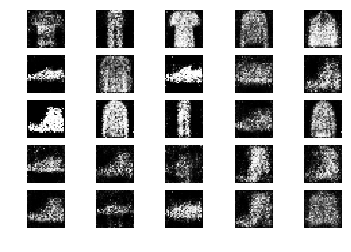

3001 [D loss: 0.642362, acc.: 68.75%] [G loss: 0.871492]
3002 [D loss: 0.652364, acc.: 67.19%] [G loss: 0.863145]
3003 [D loss: 0.695149, acc.: 59.38%] [G loss: 0.927965]
3004 [D loss: 0.669816, acc.: 57.81%] [G loss: 0.901125]
3005 [D loss: 0.620102, acc.: 64.06%] [G loss: 0.885326]
3006 [D loss: 0.638348, acc.: 62.50%] [G loss: 0.955841]
3007 [D loss: 0.652088, acc.: 59.38%] [G loss: 0.919885]
3008 [D loss: 0.661461, acc.: 60.94%] [G loss: 0.906520]
3009 [D loss: 0.653013, acc.: 60.94%] [G loss: 0.917378]
3010 [D loss: 0.677301, acc.: 59.38%] [G loss: 0.959482]
3011 [D loss: 0.602151, acc.: 65.62%] [G loss: 0.845494]
3012 [D loss: 0.629939, acc.: 65.62%] [G loss: 0.899450]
3013 [D loss: 0.728155, acc.: 53.12%] [G loss: 0.963945]
3014 [D loss: 0.623485, acc.: 57.81%] [G loss: 0.886315]
3015 [D loss: 0.688554, acc.: 53.12%] [G loss: 0.909907]
3016 [D loss: 0.638152, acc.: 62.50%] [G loss: 0.876935]
3017 [D loss: 0.686699, acc.: 60.94%] [G loss: 0.884458]
3018 [D loss: 0.685946, acc.: 5

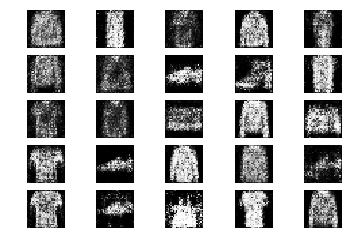

3501 [D loss: 0.617412, acc.: 71.88%] [G loss: 0.872653]
3502 [D loss: 0.663734, acc.: 54.69%] [G loss: 0.864311]
3503 [D loss: 0.740129, acc.: 53.12%] [G loss: 0.924865]
3504 [D loss: 0.587927, acc.: 71.88%] [G loss: 0.924618]
3505 [D loss: 0.695955, acc.: 54.69%] [G loss: 0.781541]
3506 [D loss: 0.648511, acc.: 71.88%] [G loss: 0.942832]
3507 [D loss: 0.665836, acc.: 59.38%] [G loss: 0.872386]
3508 [D loss: 0.722619, acc.: 56.25%] [G loss: 0.838535]
3509 [D loss: 0.642881, acc.: 60.94%] [G loss: 0.834544]
3510 [D loss: 0.709908, acc.: 53.12%] [G loss: 0.879641]
3511 [D loss: 0.638860, acc.: 65.62%] [G loss: 0.931477]
3512 [D loss: 0.639980, acc.: 67.19%] [G loss: 0.861632]
3513 [D loss: 0.626476, acc.: 70.31%] [G loss: 0.841377]
3514 [D loss: 0.607939, acc.: 68.75%] [G loss: 0.927807]
3515 [D loss: 0.632706, acc.: 64.06%] [G loss: 0.853031]
3516 [D loss: 0.651347, acc.: 60.94%] [G loss: 0.887222]
3517 [D loss: 0.671199, acc.: 56.25%] [G loss: 0.885141]
3518 [D loss: 0.575089, acc.: 7

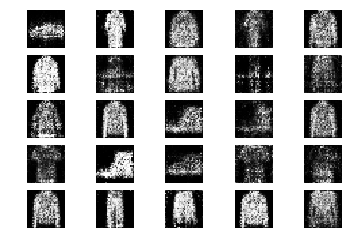

4001 [D loss: 0.707377, acc.: 54.69%] [G loss: 0.877856]
4002 [D loss: 0.668691, acc.: 56.25%] [G loss: 0.909993]
4003 [D loss: 0.647542, acc.: 53.12%] [G loss: 0.918207]
4004 [D loss: 0.618144, acc.: 68.75%] [G loss: 0.866110]
4005 [D loss: 0.666322, acc.: 59.38%] [G loss: 0.865081]
4006 [D loss: 0.632977, acc.: 64.06%] [G loss: 0.898162]
4007 [D loss: 0.649931, acc.: 54.69%] [G loss: 0.862525]
4008 [D loss: 0.631948, acc.: 60.94%] [G loss: 0.919702]
4009 [D loss: 0.589697, acc.: 68.75%] [G loss: 0.968230]
4010 [D loss: 0.679917, acc.: 65.62%] [G loss: 0.885370]
4011 [D loss: 0.669186, acc.: 57.81%] [G loss: 0.918742]
4012 [D loss: 0.620950, acc.: 59.38%] [G loss: 0.872303]
4013 [D loss: 0.655056, acc.: 57.81%] [G loss: 0.885896]
4014 [D loss: 0.646475, acc.: 59.38%] [G loss: 0.861571]
4015 [D loss: 0.622682, acc.: 64.06%] [G loss: 0.861788]
4016 [D loss: 0.694972, acc.: 51.56%] [G loss: 0.876552]
4017 [D loss: 0.646225, acc.: 62.50%] [G loss: 0.912119]
4018 [D loss: 0.633686, acc.: 6

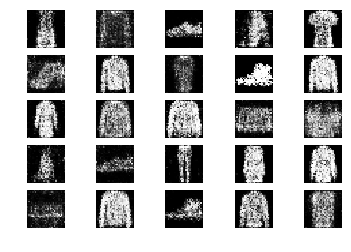

4501 [D loss: 0.599073, acc.: 68.75%] [G loss: 0.849157]
4502 [D loss: 0.686711, acc.: 59.38%] [G loss: 0.885785]
4503 [D loss: 0.654488, acc.: 62.50%] [G loss: 0.891959]
4504 [D loss: 0.727143, acc.: 57.81%] [G loss: 0.880089]
4505 [D loss: 0.634292, acc.: 62.50%] [G loss: 0.853904]
4506 [D loss: 0.623312, acc.: 65.62%] [G loss: 0.948364]
4507 [D loss: 0.658545, acc.: 57.81%] [G loss: 0.880201]
4508 [D loss: 0.637270, acc.: 64.06%] [G loss: 0.949657]
4509 [D loss: 0.653808, acc.: 65.62%] [G loss: 0.967943]
4510 [D loss: 0.713180, acc.: 51.56%] [G loss: 0.866881]
4511 [D loss: 0.610846, acc.: 60.94%] [G loss: 0.835977]
4512 [D loss: 0.650023, acc.: 62.50%] [G loss: 0.903542]
4513 [D loss: 0.647273, acc.: 67.19%] [G loss: 0.903755]
4514 [D loss: 0.672531, acc.: 51.56%] [G loss: 0.908823]
4515 [D loss: 0.636662, acc.: 62.50%] [G loss: 0.913179]
4516 [D loss: 0.657918, acc.: 62.50%] [G loss: 0.877177]
4517 [D loss: 0.644615, acc.: 65.62%] [G loss: 0.890060]
4518 [D loss: 0.634242, acc.: 6

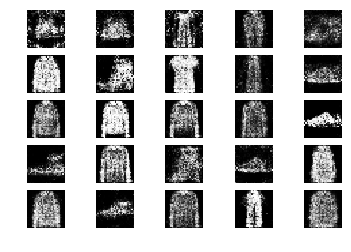

In [12]:
# train and test the model
gan = GAN()
gan.train(epochs=5001, batch_size=32, sample_interval=500)